In [14]:
import Modules.SQcircuit_extensions as sq_ext
import Modules.figures as figs
import SQcircuit as sq
import numpy as np
import matplotlib.pyplot as plt
import importlib
import os
import qutip as qt
from scipy.optimize import curve_fit
import pickle

importlib.reload(sq_ext)
importlib.reload(sq)
importlib.reload(figs)

<module 'Modules.figures' from 'C:\\Users\\gabri\\PycharmProjects\\tunable-capacitive-coupling-flux-qubits\\Modules\\figures.py'>

<Figure size 640x480 with 0 Axes>

In [15]:
# %matplotlib ipympl
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })
plt.rcParams['text.usetex'] = False

np.set_printoptions(linewidth=300, formatter={'float': '{:.12f}'.format})

In [16]:
fF  = 1e-15
nH  = 1e-9
GHz = 1e9
h   = 6.626e-34
e0  = 1.602e-19
Φ_0 = h / (2 * e0)

# Theoretical model Jx Jy Jz

In [17]:
fq2_set_vec = np.array([3.62  , 3.6245, 3.629 , 3.6335, 3.638 , 3.6425, 3.647 , 3.6515,
       3.656 , 3.6605, 3.665 , 3.6695, 3.674 , 3.6785, 3.683 , 3.6875,
       3.692 , 3.6965, 3.701 , 3.7055, 3.71  ])
f2_of_max_g = 3.6587
x0_array_opt = np.array([0.00026772, 0.00030737, 0.00034445, 0.00042214, 0.00055151,
       0.00069153, 0.00096878, 0.        , 0.        , 0.        ,
       0.0014975 , 0.0010779 , 0.00085284, 0.00067319, 0.00059366,
       0.00048784, 0.00044596, 0.00041887, 0.00035964, 0.00038036,
       0.00031654])

In [18]:
opt_dir = 'C:/Users/gabri/PycharmProjects/tunable-capacitive-coupling-flux-qubits/KIT/spectral_data_KIT/opt_results'
CF_1, LF_1, EJ_1, _, _      = np.load(opt_dir +  '/qubit_1' + '.npz')['parameters_opt']
C_int_11, CR_1, LR_1, _, _  = np.load(opt_dir +  '/resonator_1' + '.npz')['parameters_opt']
CF_2, LF_2, EJ_2, _, _      = np.load(opt_dir +  '/qubit_2' + '.npz')['parameters_opt']
CR_2, LR_2, Δ_2, _, _       = np.load(opt_dir +  '/resonator_2' + '.npz')['parameters_opt']
CF_3, LF_3, EJ_3, _, _      = np.load(opt_dir +  '/qubit_3' + '.npz')['parameters_opt']
C_int_33, CR_3, LR_3, _, _  = np.load(opt_dir +  '/resonator_3' + '.npz')['parameters_opt']
C_int_12, _, _, _           = np.load(opt_dir +  '/qubit_1_qubit_2' + '.npz')['parameters_opt']
C_int_12, C_int_23, C_int_13, _, _, _, _, _, _, _, _, _= np.load(opt_dir +  '/qubit_1_qubit_2_qubit_3' + '.npz')['parameters_opt'] 

In [19]:
C11 = CF_1
C22 = CF_2
C33 = CF_3

C12 = 0.0525
C21 = 0.0525
C23 = 0.0525
C32 = 0.0525

C13 = 0.0015
C31 = C13

C = np.array([ [C11, C12, C13], [C21, C22, C23], [C31, C32, C33] ])
C_inv = np.linalg.inv(C)
C_mat = C_inv

In [20]:
nmax_f = 10
nmax_r =5
# φ_ext_2_values = np.linspace(0.5165,0.519,100)
n_eig_circuits=3
n_eig_qubit=4
extra_eigs = 10

In [21]:
def calc_effective_qq_coupling(φ_ext_2, C_inv):
    
    
    ω_1 = sq_ext.diag(fluxonium_1.hamiltonian(),2,remove_ground=True)[0][1]
    ω_3 = sq_ext.diag(fluxonium_3.hamiltonian(),2,remove_ground=True)[0][1]
    
    fluxonium_2 = sq_ext.sq_fluxonium(C_F_eff=C_inv[1, 1] ** -1, L_F_eff = LF_2, EJ=EJ_2, nmax_f=nmax_f, φ_ext=φ_ext_2)
    ω_2 = sq_ext.diag(fluxonium_2.hamiltonian(),2,remove_ground=True)[0][1]
    Δfq2 = (ω_2 - ω_1)*1e3
    
    circuits = [fluxonium_1, fluxonium_2, fluxonium_3]
    H_circuits = [circuit.hamiltonian() for circuit in circuits]
    E_circuits = [sq_ext.diag(H, n_eig_circuits, solver='numpy')[0] for H in H_circuits]
    ψ_circuits = [sq_ext.diag(H, n_eig_circuits, solver='numpy')[1] for H in H_circuits]
    
    H_0, H   = sq_ext.hamiltonian_fluxonium_C_fluxonium_C_fluxonium(C_inv, circuits, nmax_f=nmax_f, return_H_0=True)
    V = H-H_0

    ψ_00 = qt.tensor([qt.Qobj(ψ_circuits[0][:,0]), qt.Qobj(ψ_circuits[1][:,0]), qt.Qobj(ψ_circuits[2][:,0])])
    ψ_10 = qt.tensor([qt.Qobj(ψ_circuits[0][:,1]), qt.Qobj(ψ_circuits[1][:,0]), qt.Qobj(ψ_circuits[2][:,0])])
    ψ_01 = qt.tensor([qt.Qobj(ψ_circuits[0][:,0]), qt.Qobj(ψ_circuits[1][:,0]), qt.Qobj(ψ_circuits[2][:,1])])
    ψ_11 = qt.tensor([qt.Qobj(ψ_circuits[0][:,1]), qt.Qobj(ψ_circuits[1][:,0]), qt.Qobj(ψ_circuits[2][:,1])])

    ψ_0 = [ψ_00,ψ_01,ψ_10,ψ_11]
    
    ψ_010 = qt.tensor([qt.Qobj(ψ_circuits[0][:,0]), qt.Qobj(ψ_circuits[1][:,1]), qt.Qobj(ψ_circuits[2][:,0])])
    
    ψ_110 = qt.tensor([qt.Qobj(ψ_circuits[0][:,1]), qt.Qobj(ψ_circuits[1][:,1]), qt.Qobj(ψ_circuits[2][:,0])])
    ψ_011 = qt.tensor([qt.Qobj(ψ_circuits[0][:,0]), qt.Qobj(ψ_circuits[1][:,1]), qt.Qobj(ψ_circuits[2][:,1])])
    ψ_111 = qt.tensor([qt.Qobj(ψ_circuits[0][:,1]), qt.Qobj(ψ_circuits[1][:,1]), qt.Qobj(ψ_circuits[2][:,1])])
    
    ψ_200 = qt.tensor([qt.Qobj(ψ_circuits[0][:,2]), qt.Qobj(ψ_circuits[1][:,0]), qt.Qobj(ψ_circuits[2][:,0])])
    ψ_020 = qt.tensor([qt.Qobj(ψ_circuits[0][:,0]), qt.Qobj(ψ_circuits[1][:,2]), qt.Qobj(ψ_circuits[2][:,0])])
    ψ_002 = qt.tensor([qt.Qobj(ψ_circuits[0][:,0]), qt.Qobj(ψ_circuits[1][:,0]), qt.Qobj(ψ_circuits[2][:,2])])
    
    ψ_0_high = [ψ_010, ψ_110, ψ_011, ψ_111, ψ_200, ψ_020, ψ_002]

    E_0_ψ_0  = [ np.real((ψ_0_i.dag() * H_0 * ψ_0_i).data[0,0])/2/np.pi/GHz for ψ_0_i in ψ_0]
    E_0_ψ_0_high  = [ np.real((ψ_0_i.dag() * H_0 * ψ_0_i).data[0,0])/2/np.pi/GHz for ψ_0_i in ψ_0_high]
    E_0  = sq_ext.diag(H_0 , n_eig=len(ψ_0)+extra_eigs, out='GHz', solver='scipy')[0]
    
    E_000 = E_0_ψ_0[0]
    
    E_0_ψ_0         -= E_000
    E_0_ψ_0_high    -= E_000
    E_0             -= E_000
    subspace_indices = sq_ext.find_close_indices(E_0_ψ_0, E_0)


    high_subspace_indices = sq_ext.find_close_indices(E_0_ψ_0_high, E_0)
    valid_high_indices = np.where(np.array(high_subspace_indices) > max(subspace_indices))[0]
    high_subspace_indices = [high_subspace_indices[valid_high_index] for valid_high_index in valid_high_indices]
        
    # ψ_0_high        = [ψ_0_high[index]      for index in valid_high_indices]
    # E_0_ψ_0_high    = [E_0_ψ_0_high[index]  for index in valid_high_indices]

    E, ψ = sq_ext.diag(H  , n_eig=len(ψ_0)+extra_eigs, out='GHz', solver='Qutip', qObj=True)
    ψ = ψ[subspace_indices]
    E = E[subspace_indices]
    
    # print('Punto de control 1')
    H_eff_p1  = sq_ext.H_eff_p1_large (ψ_0, H, real=True, remove_ground=True)
    H_eff_p2  = H_eff_p1 + sq_ext.H_eff_p2_large(ψ_0, ψ_0_high, E_0_ψ_0, E_0_ψ_0_high, V, remove_ground=True)
    H_eff_SWT, Qs = sq_ext.H_eff_SWT_large(ψ_0, ψ, E, remove_ground=True,return_Q=True)
    
    SWT = sq_ext.decomposition_in_pauli_4x4(H_eff_SWT , print_pretty=False)
    
    #Analytics:
    fluxonium_1.diag(2)
    fluxonium_2.diag(2)
    fluxonium_3.diag(2)
    
    Q_1 = np.abs(fluxonium_1.charge_op(0, basis='eig')[0,1])
    Q_2 = np.abs(fluxonium_2.charge_op(0, basis='eig')[0,1])
    Q_3 = np.abs(fluxonium_3.charge_op(0, basis='eig')[0,1])
    
    ω_1 = sq_ext.diag(fluxonium_1.hamiltonian(),2, remove_ground=True)[0][1]
    ω_2 = sq_ext.diag(fluxonium_2.hamiltonian(),2, remove_ground=True)[0][1]
    ω_3 = sq_ext.diag(fluxonium_3.hamiltonian(),2, remove_ground=True)[0][1]
    
    Δ_12 = (ω_1 - ω_2) # maybe change sign
    Δ_23 = (ω_3 - ω_2) 
    Σ_12 = ω_1 + ω_2
    Σ_23 = ω_3 + ω_2

    g_12 = C_inv[0, 1] * fF**-1 * Q_1 * Q_2 /2/np.pi/GHz
    g_23 = C_inv[1, 2] * fF**-1 * Q_2 * Q_3 /2/np.pi/GHz
    g_13 = C_inv[0, 2] * fF**-1 * Q_1 * Q_3 /2/np.pi/GHz

    g_eff = g_12*g_23*(1/Δ_12 + 1/Δ_23 - 1/Σ_12 - 1/Σ_23)/2 + g_13

    g_13_analytic = g_eff
    
    return Δfq2, SWT, g_13_analytic

In [22]:
φ_ext_2_values = np.concatenate((np.linspace(0.5, 0.516,51), np.linspace(0.516, 0.52,51), np.linspace(0.52, 0.54,51)))

In [23]:
SWT             = np.zeros([len(φ_ext_2_values), 4, 4])
Qs              = np.zeros([len(φ_ext_2_values), 4, 4], dtype='complex')
g_13_analytic   = np.zeros([len(φ_ext_2_values)])
Δfq2            = np.zeros([len(φ_ext_2_values)])

fluxonium_1 = sq_ext.sq_fluxonium(C_F_eff=C_inv[0, 0] ** -1, L_F_eff = LF_1, EJ=EJ_1, nmax_f=nmax_f)
fluxonium_3 = sq_ext.sq_fluxonium(C_F_eff=C_inv[2, 2] ** -1, L_F_eff = LF_3, EJ=EJ_3, nmax_f=nmax_f)

φ_ext_3_resonance = sq_ext.find_resonance(fluxonium_1.hamiltonian(), fluxonium_3)
loop_3 = fluxonium_3.loops[0]
loop_3.set_flux(φ_ext_3_resonance)

ω_1 = sq_ext.diag(fluxonium_1.hamiltonian(),2,remove_ground=True)[0][1]
ω_3 = sq_ext.diag(fluxonium_3.hamiltonian(),2,remove_ground=True)[0][1]

In [24]:
for i, φ_ext_2 in enumerate(φ_ext_2_values):
    Δfq2[i], SWT[i,:], g_13_analytic[i] = calc_effective_qq_coupling(φ_ext_2, C_inv)

C:\Users\gabri\PycharmProjects\tunable-capacitive-coupling-flux-qubits\Modules\SQcircuit_extensions.py:1811: ComplexWarning: Casting complex values to real discards the imaginary part
  P[i, j] = 0.25 * (np.dot(S.T.conjugate(), A)).trace() # P[i,j]=(1/4)tr(S_ij^t*A)


KeyboardInterrupt: 

In [160]:
σxσx = np.abs(SWT[:, 1, 1])
σyσy = np.abs(SWT[:, 2, 2])
σzσz = np.abs(SWT[:, 3, 3])

In [168]:
i=70
σxσx[i]*1e3, σyσy[i]*1e3, σzσz[i]*1e3

(0.007155023224180454, 0.4974840867224004, 0.0033537798667104823)

In [169]:
(σxσx+σyσy)/σzσz

array([1320.484498015260, 1319.242732967463, 1315.518523883772, 1309.314043685248, 1300.626923215122, 1289.467867247466, 1275.839193390315, 1259.756541101019, 1241.231194690731, 1220.278647194665, 1196.917549259195, 1171.164682417179, 1143.058340167917, 1112.627248198688, 1079.909239307391,
       1044.947709488018, 1007.802118935688, 968.529943601923, 927.209311088842, 883.917011112280, 838.751536721334, 791.818050984990, 743.241204539911, 693.155104923790, 641.717157239437, 589.095928959367, 535.477464210565, 481.075073681453, 426.111141106020, 370.835469949951, 315.513399159573,
       260.432548227476, 205.898101954535, 152.234008342396, 99.780550258739, 48.892208613424, 2.559795537823, 49.239255936754, 93.230573912553, 134.151621476333, 171.624401737725, 205.279028169782, 234.759604255461, 259.730324952508, 279.880550230347, 294.930366666463, 304.637714274271,
       308.803349357941, 307.276606263162, 299.962547082841, 286.830321252567, 286.830287497212, 282.641462464030, 278.092

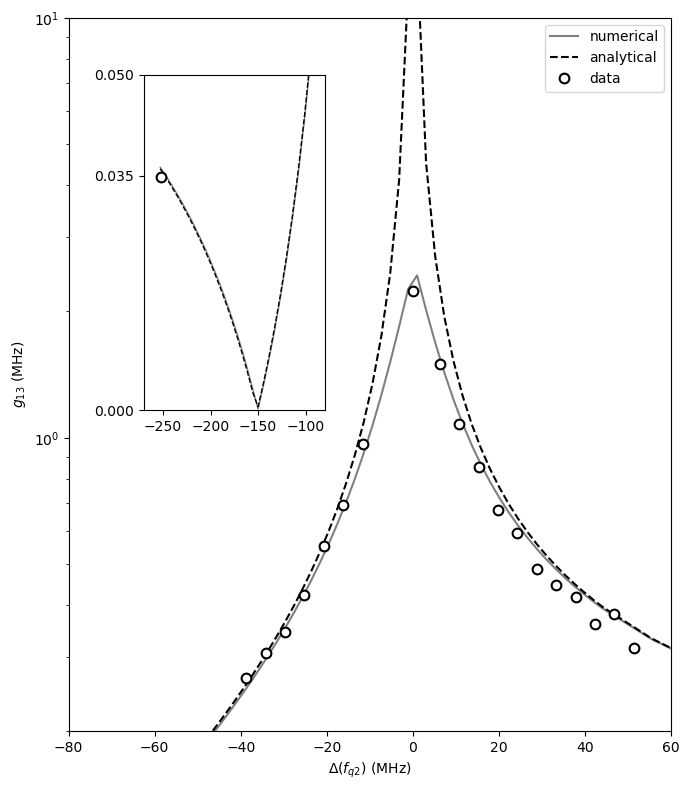

In [74]:
fig, ax = plt.subplots(1, 1, figsize = (7, 8), dpi = 100)

ms = 7
mew = 1.5

detuned_Δfq2 = -252
detuned_g13 = 0.04917

ax.plot(Δfq2 , (σyσy + σxσx)  * 1e3, '-', color='gray', label = 'numerical')
#ax.plot(Δfq2 , σzσz  * 1e3, color=colors[2], linestyle=':')
ax.plot(Δfq2 , np.abs(g_13_analytic)  * 1e3, '--', color='k', label = 'analytical')

ax.set_xlim(-260, 300)
#ax.yaxis.tick_right()

ax.plot((fq2_set_vec[:7]-f2_of_max_g)*1e3, x0_array_opt[:7]*1e3, color='k', marker='o', mfc = 'white', mew = mew, ls='', ms=ms,label='data')
ax.plot((fq2_set_vec[10:]-f2_of_max_g)*1e3, x0_array_opt[10:]*1e3, color='k', marker='o', mfc = 'white', mew = mew, ls='', ms=ms)
ax.plot(0,3.16/np.sqrt(2), color='k', marker='o', mfc = 'white', mew = mew, ls='', ms=ms)


ax.set_yscale('log')

ax.set_xlabel(r'$\Delta(f_{q2})$ (MHz)')
ax.set_ylabel(r'$g_{13}$ (MHz)')

ax.set_ylim([20e-2, 10])
ax.set_xlim([-80, 60])

# inset Axes....
x1, x2, y1, y2 = -270, -80, 1e-4, 5e-2  # subregion of the original image
axins = ax.inset_axes(
    [0.125, 0.45, 0.3, 0.47],
    xlim=(x1, x2), ylim=(y1, y2))
axins.plot(Δfq2 , (σyσy + σxσx)  * 1e3, '-', lw = 1, color='gray', label = 'theory (numerical)')
axins.plot(Δfq2 , np.abs(g_13_analytic)  * 1e3, '--', lw = 1, color='k', label = 'theory (analytical)')
axins.plot(detuned_Δfq2, detuned_g13/np.sqrt(2), marker='o', mew = mew, ls='', color='k', mfc = 'white', ms=ms)
axins.set_yticks([0, 0.035, 0.05])

# ax.indicate_inset_zoom(axins, edgecolor="black")
ax.legend(loc = 'upper right')

fig.tight_layout()

plt.savefig("g_13.pdf", format="pdf", bbox_inches="tight")


# Export or show the figure
# fig.show()

# Experimental data

## zz interaction (can we call it like that?)

<img src='./img/pulse_sequence.png'> 

+ qubits 1 and 3 are kept on resonance around 3.689 GHz --> They hybridize to |+> and |->, which is basically degenerate because the coupler q2 is far detuned

+ We measure Ramsey interferometry on qubit 1 while moving the coupler qubit via the fast flux bias line closer to the avoided crossing (in real time, meaning that we fill the waiting times in the Ramsey interferometry with the flux bias line pulses. When playing the pulses on qubits 1 and 3, the coupler is always detuned). The dynamics of this experiment should happen in the 1-photon subspace (left)

+ We repeat the above experiment by playing a pi-pulse on q3 before the Ramsey. The dynamics should now happen in the 2-photon subspace (right)

+ For both experiments, we can extract the q1 frequency from the Ramsey fringes versus coupler detuning $\delta \omega$, which gives us two avoided crossings which are shifted along $\delta \omega$. We interpret this shift as the zz-interaction between q1 and q3.

<img src='./img/subspaces.png'> 

### "Raw" data: Ramsey fringes versus coupler detuning

In [318]:
data_dir = r'C:/Users/gabri/PycharmProjects/tunable-capacitive-coupling-flux-qubits/KIT/spectral_data_KIT/data'

In [319]:
with open(data_dir + r'/zz_Ramsey_t_us.pkl', 'rb') as f:
    t_us = pickle.load(f)
with open(data_dir + r'/zz_Ramsey_a_vec.pkl', 'rb') as f:
    a_vec = pickle.load(f)

with open(data_dir + r'/zz_Ramsey_q1_x_0.pkl', 'rb') as f:
    q1_x_0 = pickle.load(f)
with open(data_dir + r'/zz_Ramsey_q1_y_0.pkl', 'rb') as f:
    q1_y_0 = pickle.load(f)
    
with open(data_dir + r'/zz_Ramsey_q1_x_1.pkl', 'rb') as f:
    q1_x_1 = pickle.load(f)
with open(data_dir + r'/zz_Ramsey_q1_y_1.pkl', 'rb') as f:
    q1_y_1 = pickle.load(f)

In [320]:
def meas_to_prob(meas):
    meas -= meas.mean()
    meas /= np.abs(meas).max()
    meas /= 2
    meas += 0.5
    return meas

In [321]:
for i in range(a_vec.size):
    q1_x_0[i,:] = meas_to_prob( q1_x_0[i,:])
    q1_y_0[i,:] = meas_to_prob( q1_y_0[i,:])
    q1_x_1[i,:] = meas_to_prob( q1_x_1[i,:])
    q1_y_1[i,:] = meas_to_prob( q1_y_1[i,:])

In [322]:
def lin_fit(x,m,n):
    return(m*x+n)

In [323]:
# linear fit results to translate dimensionless power factor 'a_vec' into actual quit 2 frequency 
# (derived above in g_13 over flux)
m_q2_acq3 = 1.089716319656597
n_q2_acq3 = 3.2120474065249

fq2_vec = lin_fit(a_vec,m_q2_acq3,n_q2_acq3)


Text(0.5, 0, 'FBL pulse time (us)')

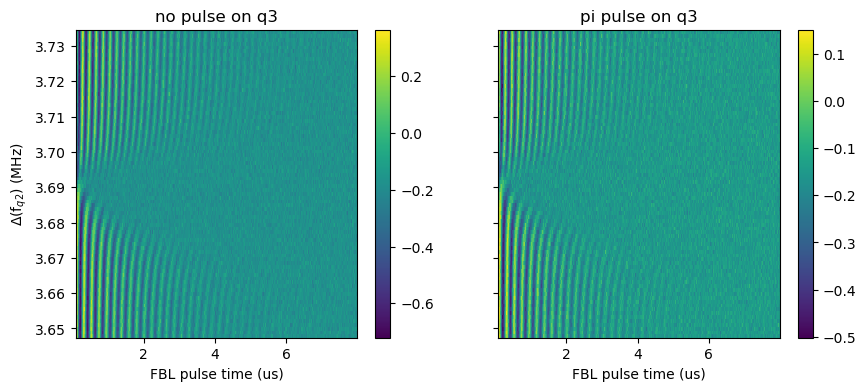

In [67]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4), sharey = True)

ax[0].set_title('no pulse on q3')
c = ax[0].pcolor(t_us, fq2_vec, q1_y_0, shading = 'auto')
fig.colorbar(c, ax = ax[0])
ax[0].set_xlabel('FBL pulse time (us)')
ax[0].set_ylabel('$\Delta$(f$_{q2}$) (MHz)')

ax[1].set_title('pi pulse on q3')
c = ax[1].pcolor(t_us, fq2_vec, q1_y_1, shading = 'auto')
fig.colorbar(c, ax = ax[1])
ax[1].set_xlabel('FBL pulse time (us)')

Text(0.5, 0, 'FBL pulse time (us)')

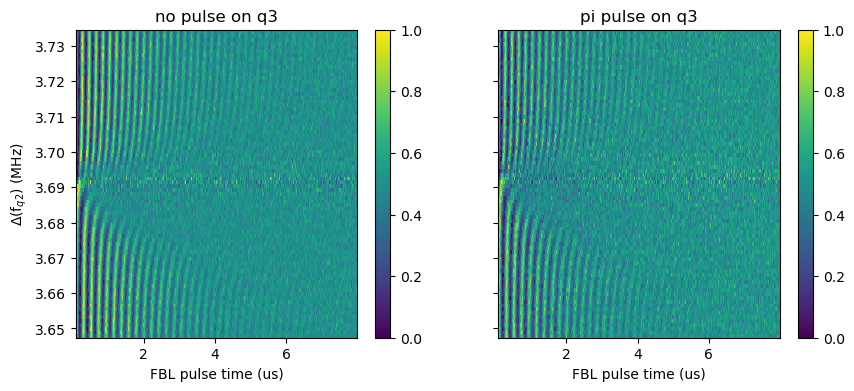

In [65]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4), sharey = True)

ax[0].set_title('no pulse on q3')
c = ax[0].pcolor(t_us, fq2_vec, q1_x_0, shading = 'auto')
fig.colorbar(c, ax = ax[0])
ax[0].set_xlabel('FBL pulse time (us)')
ax[0].set_ylabel('$\Delta$(f$_{q2}$) (MHz)')

ax[1].set_title('pi pulse on q3')
c = ax[1].pcolor(t_us, fq2_vec, q1_x_1, shading = 'auto')
fig.colorbar(c, ax = ax[1])
ax[1].set_xlabel('FBL pulse time (us)')

(0.0, 2.2)

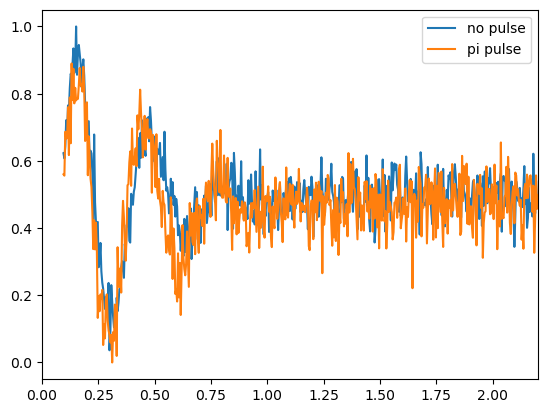

In [70]:
plt.plot(t_us, q1_x_0[35,:], label = 'no pulse')
plt.plot(t_us, q1_x_1[35,:], label = 'pi pulse')

plt.legend()
plt.xlim([0, 2.2])

In [71]:
FFT = np.abs(np.fft.fft(q1_x_0))
n = t_us.size
timestep = t_us[1] - t_us[0]
freq = np.fft.fftfreq(n, d=timestep)
freq_pos = freq[1:-freq.size//2]
FFT_pos = FFT[:,1:-FFT.shape[1]//2]
FFT_0 = FFT_pos
delta_vec_0= freq_pos[np.argmax(FFT_pos, axis = 1)]


FFT = np.abs(np.fft.fft(q1_x_1))
n = t_us.size
timestep = t_us[1] - t_us[0]
freq = np.fft.fftfreq(n, d=timestep)
freq_pos = freq[1:-freq.size//2]
FFT_pos = FFT[:,1:-FFT.shape[1]//2]
FFT_1 = FFT_pos
delta_vec_1= freq_pos[np.argmax(FFT_pos, axis = 1)]

C:\Users\gabri\AppData\Local\Temp\ipykernel_11884\181501907.py:10: UserWarning: Matplotlib is currently using QtAgg, which is a non-GUI backend, so cannot show the figure.
  fig.show()


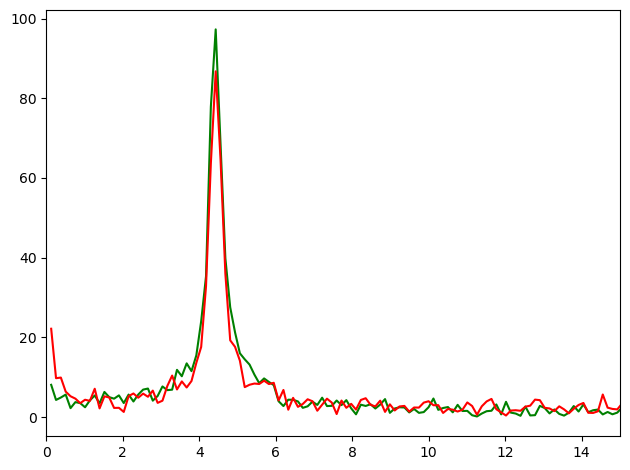

In [72]:
idx=20

fig, ax = plt.subplots()

ax.plot(freq_pos, FFT_0[idx], 'g')
ax.plot(freq_pos, FFT_1[idx], 'r')

ax.set_xlim(0,15)
fig.tight_layout()
fig.show()

In [131]:
def symbolic_fft(J, Jz, gamma, omega):
    # Define components of the numerator and denominator
    numerator = (-2 * omega**2 * (J**2 + 4 * Jz**2) * ((J**2 - 4 * Jz**2)**2 - gamma**2 * (J**2 + 4 * Jz**2))
                 + (gamma**2 * (J**2 + 4 * Jz**2) + (J**2 - 4 * Jz**2)**2)**2
                 + omega**4 * (J**2 + 4 * Jz**2)**2)
    
    term1 = (gamma**2 + (J - 2 * Jz)**2)**2 - 2 * omega**2 * (-gamma + J - 2 * Jz) * (gamma + J - 2 * Jz) + omega**4
    term2 = (gamma**2 + (J + 2 * Jz)**2)**2 - 2 * omega**2 * (-gamma + J + 2 * Jz) * (gamma + J + 2 * Jz) + omega**4
    denominator = 4 * (gamma**2 + omega**2) * term1 * term2
    
    return numerator / denominator

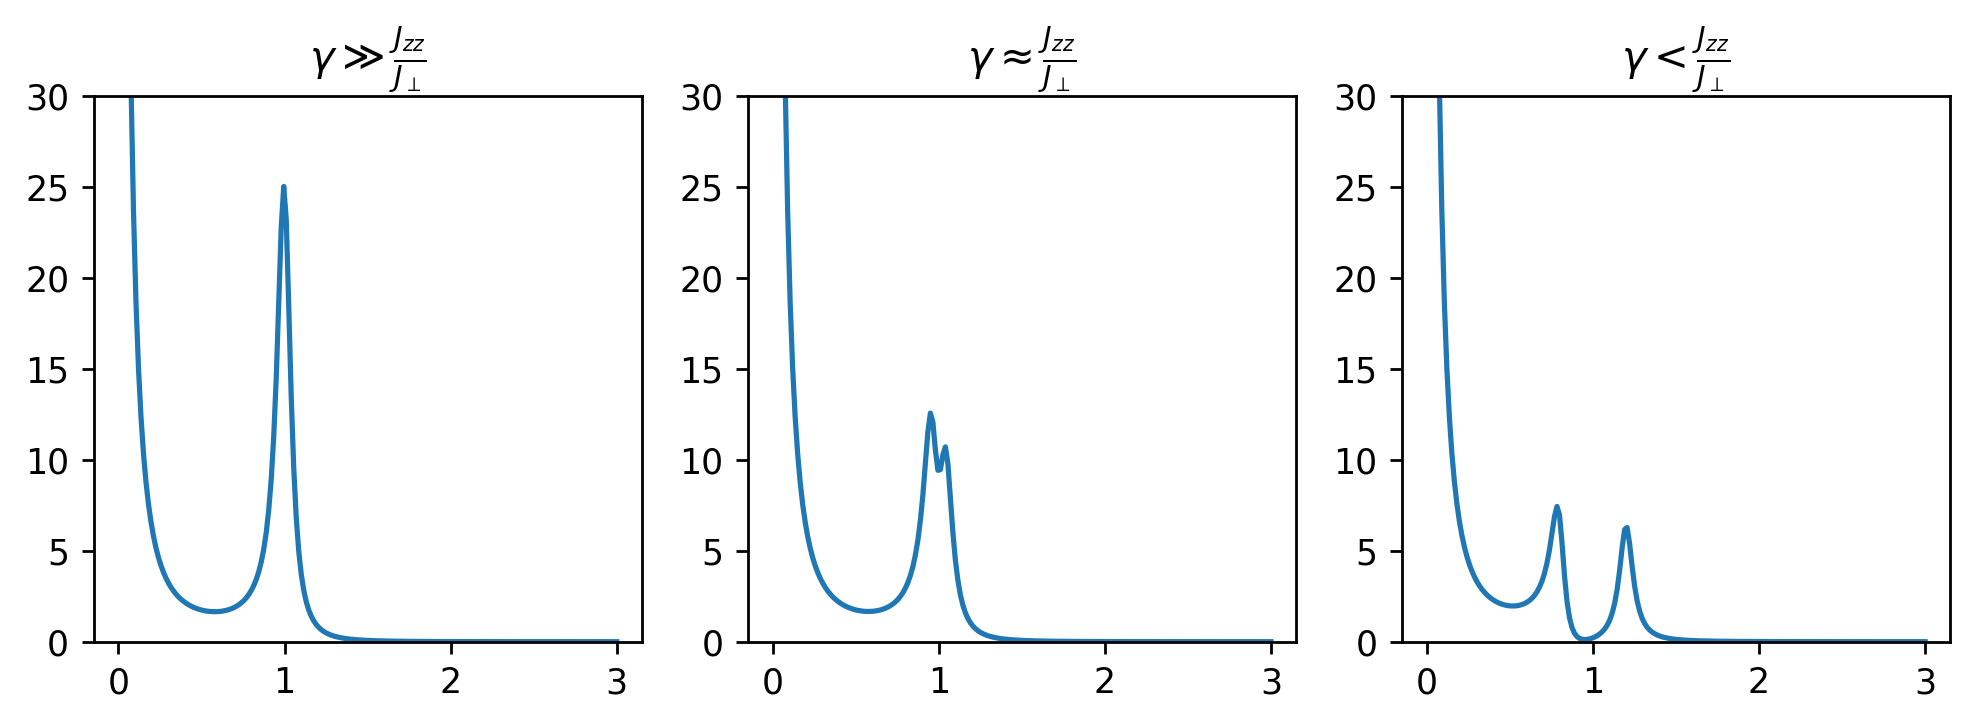

In [198]:
omega = np.linspace(0,3, 200)
J =1
gamma = 0.05

fig, [ax1, ax2, ax3] = plt.subplots(ncols=3, figsize=np.array([8,3]), dpi=250)

ax1.plot(omega, symbolic_fft(J, gamma/100, gamma, omega))
ax2.plot(omega, symbolic_fft(J, gamma*0.4, gamma, omega))
ax3.plot(omega, symbolic_fft(J, 2*gamma, gamma, omega))

#ax.set_ylabel(r'$')
#ax.set_xlabel(r'$')
ax1.set_title(r'$\gamma \gg  \frac{ J_{zz}}{J_\perp}$')
ax2.set_title(r'$\gamma \approx  \frac{ J_{zz}}{J_\perp}$')
ax3.set_title(r'$\gamma <  \frac{ J_{zz}}{J_\perp}$')
ax1.set_ylim([0,30])
ax2.set_ylim([0,30])
ax3.set_ylim([0,30])
fig.tight_layout()

figs.export('fft_vs_gamma.pdf', fig=fig)

(-5.0, 5.0)

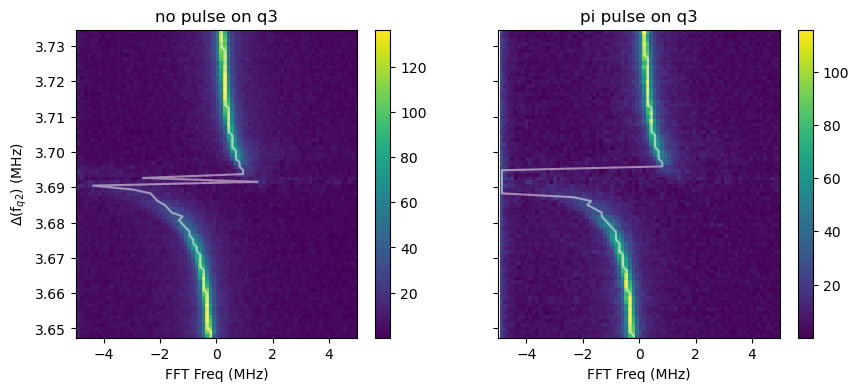

In [73]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4), sharey = True)

ax[0].set_title('no pulse on q3')
c = ax[0].pcolor(freq_pos - 5, fq2_vec, FFT_0, shading = 'auto')
ax[0].plot(delta_vec_0-5, fq2_vec, color = 'white', alpha = .5)
fig.colorbar(c, ax = ax[0])
ax[0].set_xlabel('FFT Freq (MHz)')
ax[0].set_ylabel('$\Delta$(f$_{q2}$) (MHz)')
ax[0].set_xlim([-5, 5])

ax[1].set_title('pi pulse on q3')
c = ax[1].pcolor(freq_pos - 5, fq2_vec, FFT_1, shading = 'auto')
ax[1].plot(delta_vec_1-5, fq2_vec, color = 'white', alpha = .5)
fig.colorbar(c, ax = ax[1])
ax[1].set_xlabel('FFT Freq (MHz)')
ax[1].set_xlim([-5,5])

## FFT not precise enough --> fit oscillations 

In [345]:
T2_vec_0 = np.empty(len(a_vec))
f_vec_0 = np.empty(len(a_vec))
T2_vec_1 = np.empty(len(a_vec))
f_vec_1 = np.empty(len(a_vec))
f1_vec_1 = np.empty(len(a_vec))
f2_vec_1 = np.empty(len(a_vec))
error_f_vec_0 = np.empty(len(a_vec))
error_f_vec_1 = np.empty(len(a_vec))

popt_list_0 = np.zeros([a_vec.size,5])
popt_list_1 = np.zeros([a_vec.size,5])
popt_list_1_2freq = np.zeros([a_vec.size,7])

In [346]:
# def damped_oscillation(t, A, tau, f, phase, off):
#     return A * np.exp(- t / tau) * np.cos(2 * np.pi * f * t + phase)**2 + off

def damped_oscillation(t, A, tau, f, phase, off):
    return A * np.exp(- t / tau) * (np.sin(2 * np.pi * f * t /2 + phase)**2-0.5) + off

def damped_oscillation_2_freq(t, A, tau, f1, phase_1, off, f2, phase_2):
    return  (A * np.exp(- t / tau) * np.cos(2 * np.pi * f1 * t + phase_1) 
             * np.cos(2 * np.pi * 2 * f2 * t + phase_2) + 0.5 + off)

## First optimization using one frequency for the second protocol

In [347]:
A = 0.3
tau = 2.44
f = np.abs(delta_vec_0[0])
phase = 2.5
Offset = 0

idx = -1

for i in range(a_vec.size):
    if i ==0 or i==41:
        popt, pcov = curve_fit(damped_oscillation, t_us[:idx], q1_x_0[i,:idx], p0=[A, tau, f, phase, Offset])
    else:
        popt, pcov = curve_fit(damped_oscillation, t_us[:idx], q1_x_0[i,:idx], p0=popt)
        
    T2_vec_0[i] = popt[1]
    f_vec_0[i] = popt[2]
    error_f_vec_0[i] = pcov[2,2]
    popt_list_0[i] = popt
    
    
for i in range(a_vec.size):
    # try:
        # popt, pcov = curve_fit(damped_oscillation, t_us[:idx], q1_x_1[i,:idx], p0=[A, tau, f, phase, Offset])
    if i ==0 or i==42:
        popt, pcov = curve_fit(damped_oscillation, t_us[:idx], q1_x_1[i,:idx], p0=[A, tau, f, phase, Offset])
    else:
        popt, pcov = curve_fit(damped_oscillation, t_us[:idx], q1_x_1[i,:idx], p0=popt)
    T2_vec_1[i] = popt[1]
    f_vec_1[i] = popt[2]
    popt_list_1[i] = popt
    error_f_vec_1[i] = pcov[2,2]
    # except:
    #     continue
 

In [348]:
T2_vec_0.max(), T2_vec_1.max()

(2.581632255583202, 2.4019754220060223)

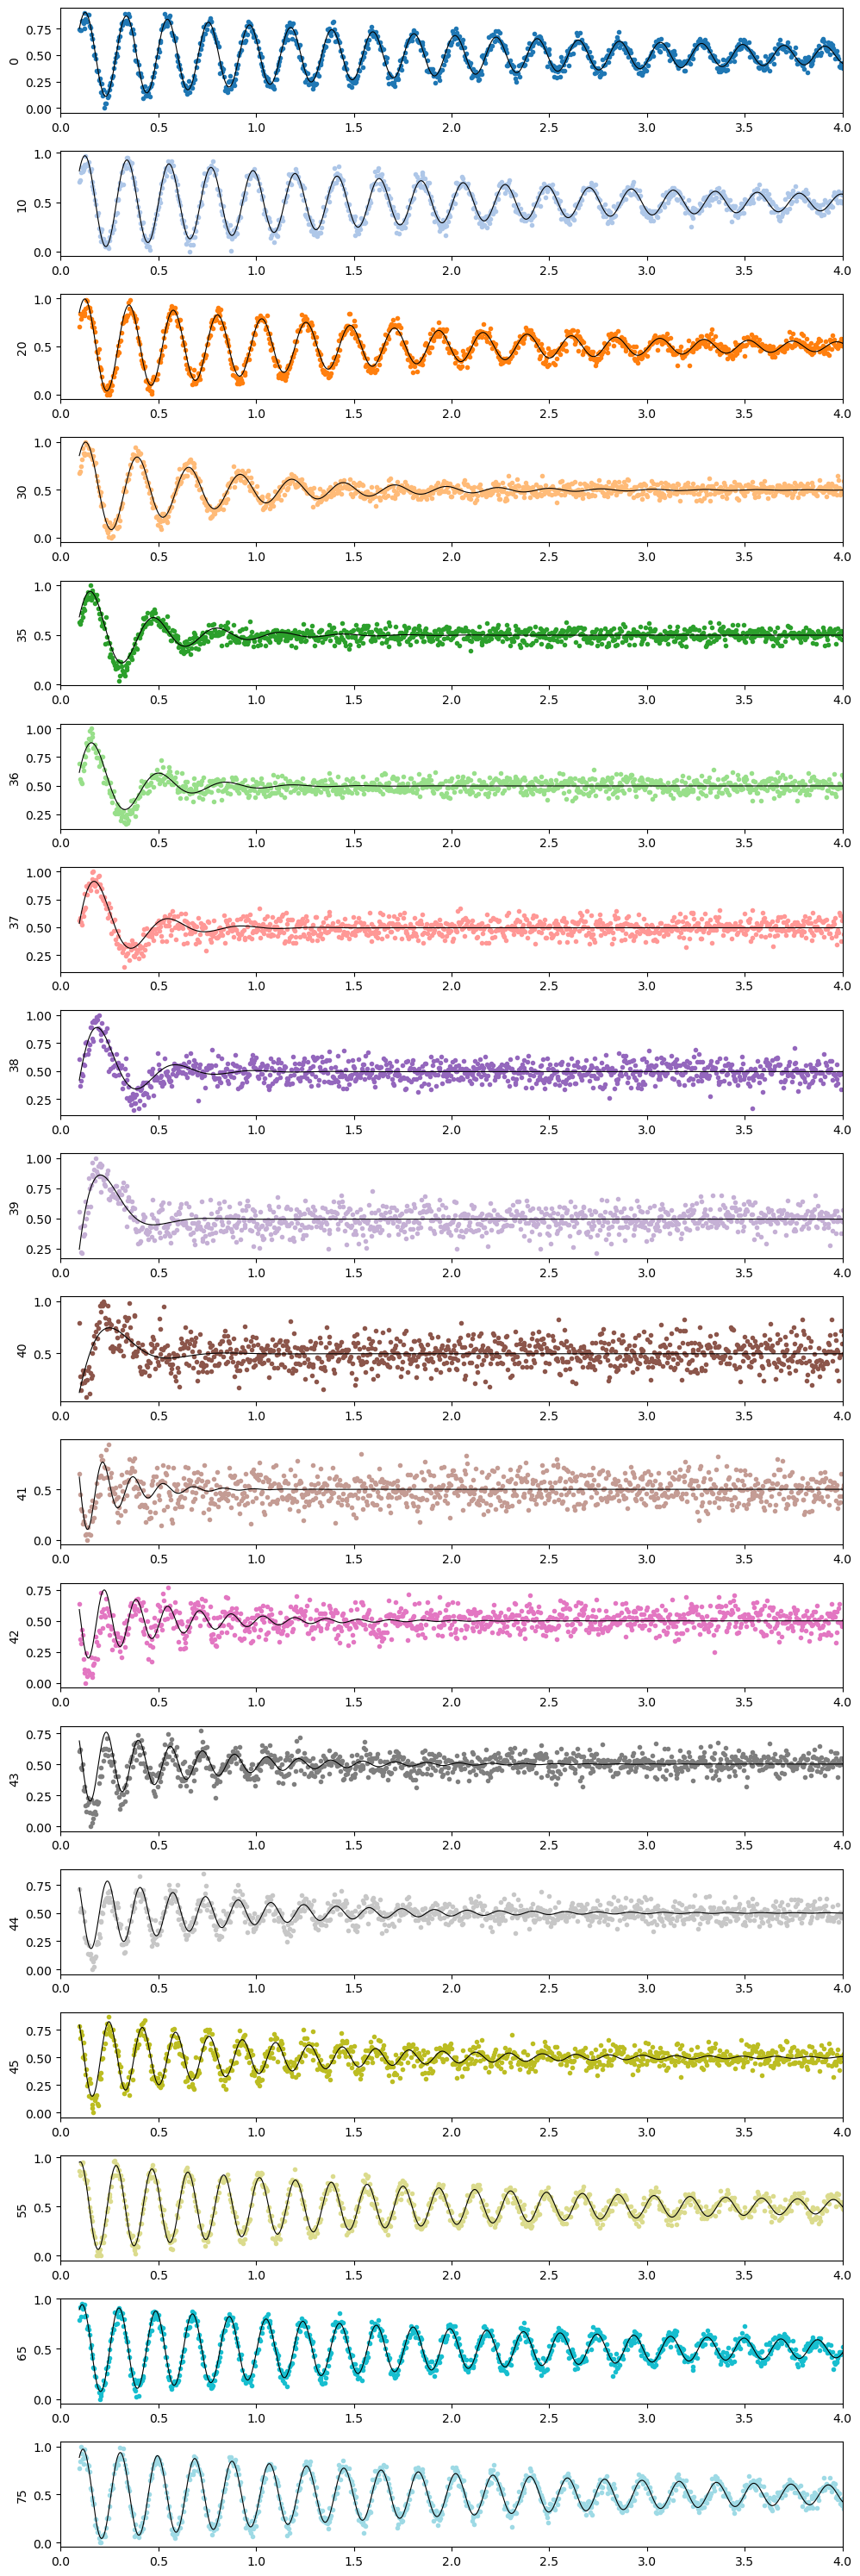

In [349]:
# indices = np.arange(0,len(q1_x_0),10)
indices = np.concatenate( (np.arange(0,35,10), np.arange(35,45), np.arange(45,len(q1_x_0),10 ) ) )
N = len(indices)
colors = figs.generate_colors_from_colormap(N , 'tab20')
fig, axs= plt.subplots(nrows=N, figsize= [ 10,30])

for n in range(N):
    axs[n].plot(t_us[:idx], q1_x_0[indices[n],:idx],'.', color=colors[n])
    axs[n].plot(t_us[:idx], damped_oscillation(t_us[:idx], *popt_list_0[indices[n]] ), 'k', linewidth=0.8)
    axs[n].set_xlim([0,4]) 
    # axs[n].set_ylabel(f'detuning={fq2_vec[i_0+n]*1e3 - 3689:.1f}')
    axs[n].set_ylabel(f'{indices[n]}')
    
fig.tight_layout()
# fig.show()

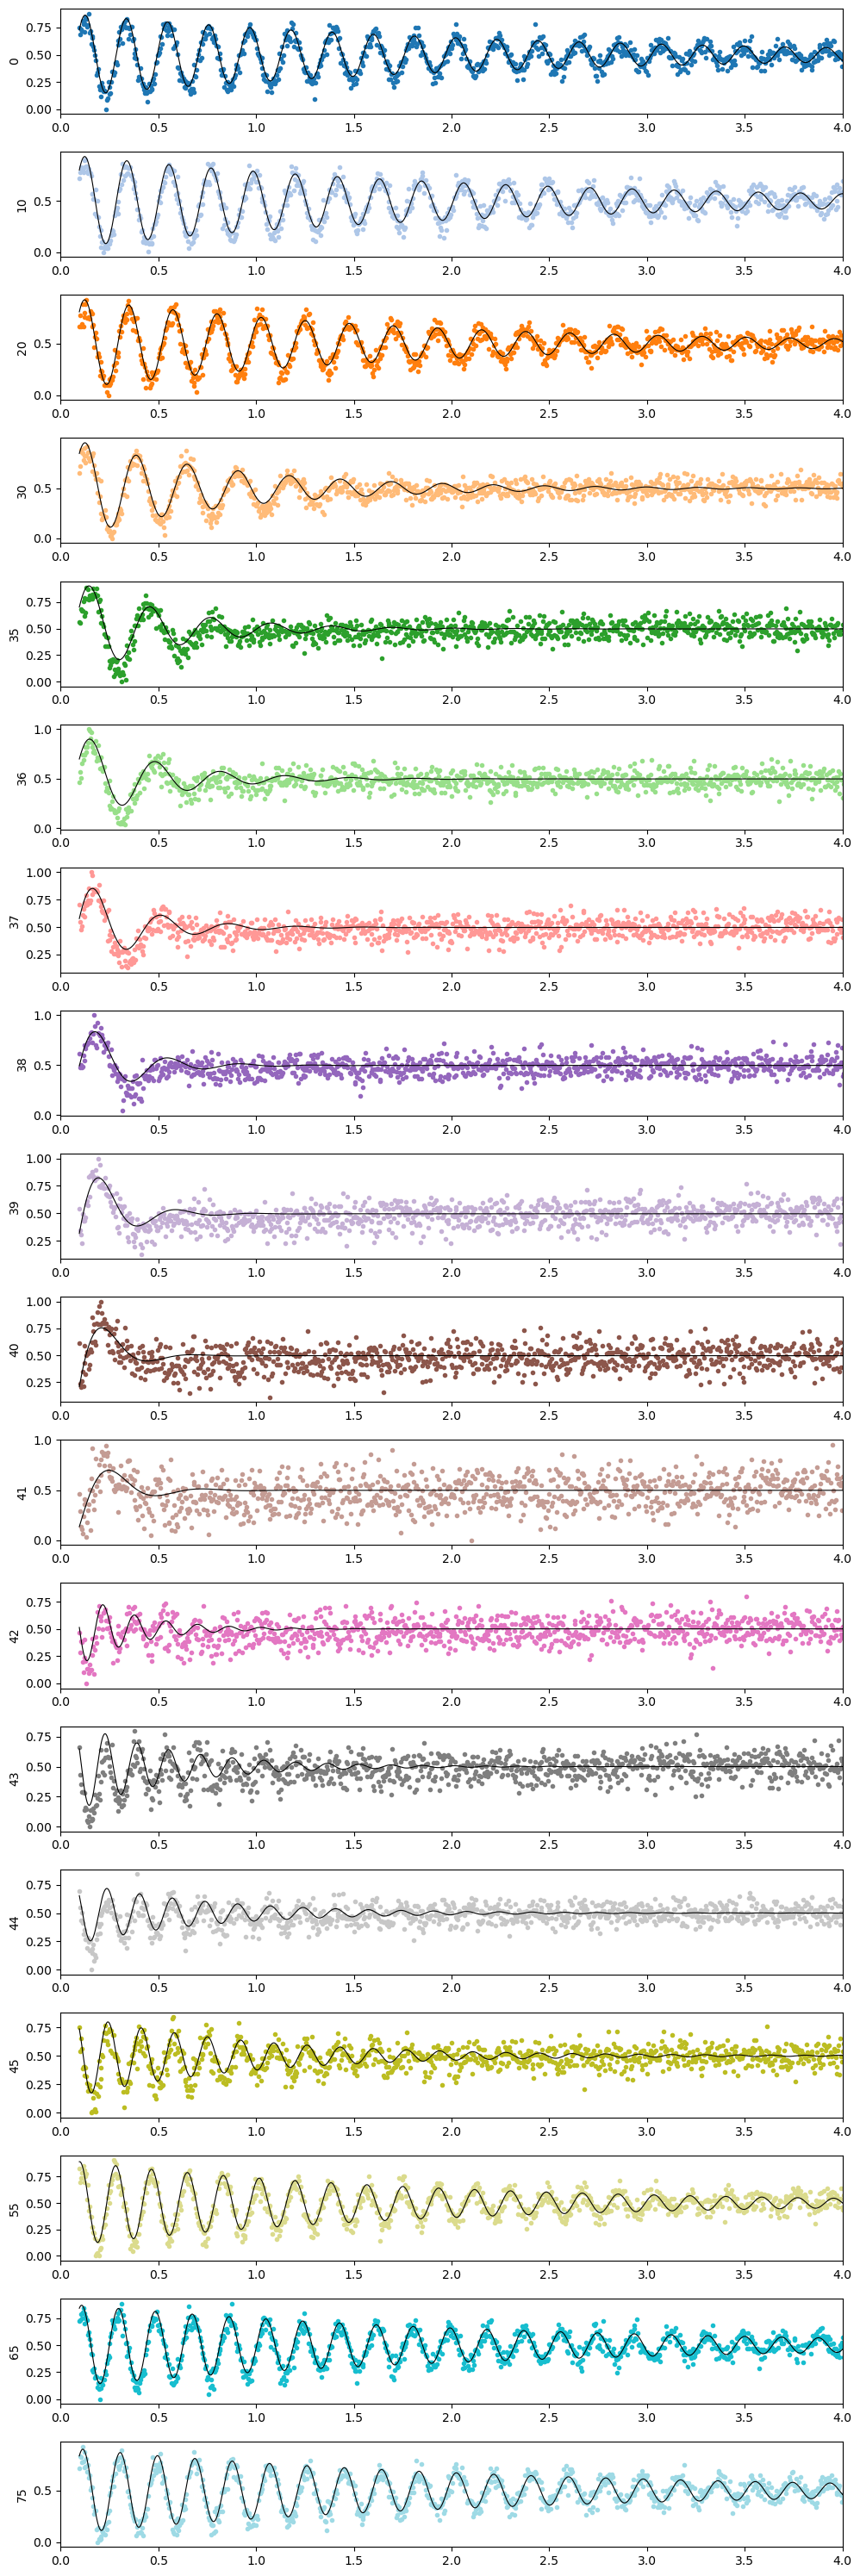

In [350]:
fig, axs= plt.subplots(nrows=N, figsize= [ 10,30])

for n in range(N):
    axs[n].plot(t_us[:idx], q1_x_1[indices[n],:idx],'.', color=colors[n])
    axs[n].plot(t_us[:idx], damped_oscillation(t_us[:idx], *popt_list_1[indices[n]] ), 'k', linewidth=0.8)
    axs[n].set_xlim([0,4]) 
    # axs[n].set_ylabel(f'detuning={fq2_vec[i_0+n]*1e3 - 3689:.1f}')
    axs[n].set_ylabel(f'{indices[n]}')
    
fig.tight_layout()
# fig.show()

Text(0, 0.5, '$\\Delta fq_1$ (MHz)')

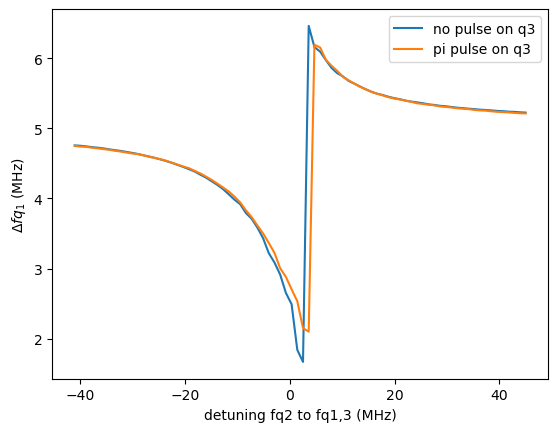

In [351]:
# The curves overlap if we move fq1_1 by 1 MHz to the "left"
plt.plot(fq2_vec*1e3 - 3689, f_vec_0, '-', label = 'no pulse on q3')
plt.plot(fq2_vec*1e3 - 3689, f_vec_1, '-', label = 'pi pulse on q3')

plt.legend()

plt.xlabel('detuning fq2 to fq1,3 (MHz)')
plt.ylabel('$\Delta fq_1$ (MHz)')

Text(0, 0.5, '$\\Delta fq_1$ (MHz)')

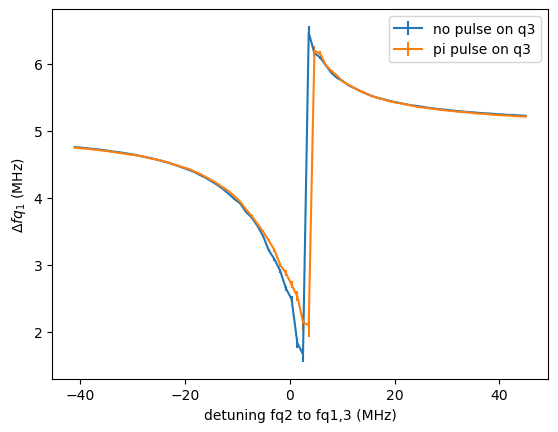

In [352]:
plt.errorbar(fq2_vec*1e3 - 3689, f_vec_0, np.sqrt(error_f_vec_0), label = 'no pulse on q3')

# The curves overlap if we move fq1_1 by 1 MHz to the "left"
plt.errorbar(fq2_vec*1e3 - 3689, f_vec_1, np.sqrt(error_f_vec_1), label = 'pi pulse on q3')

plt.legend()

plt.xlabel('detuning fq2 to fq1,3 (MHz)')
plt.ylabel('$\Delta fq_1$ (MHz)')

## Second optimization using 2 freqs for second protocol

In [353]:
   
for i in range(a_vec.size):
    if i ==0 or i==42:
        popt, pcov = curve_fit(damped_oscillation_2_freq, t_us[:idx], q1_x_1[i,:idx], p0=[*popt_list_1[i], popt_list_1[i][2]/100, 0],maxfev=10000)
    else:
        popt, pcov = curve_fit(damped_oscillation_2_freq, t_us[:idx], q1_x_1[i,:idx], p0=popt,maxfev=10000)
    T2_vec_1[i] = popt[1]
    f1_vec_1[i] = popt[2]
    f2_vec_1[i] = popt[6]
    popt_list_1_2freq[i] = popt
    error_f_vec_1[i] = pcov[2,2]
    # except:
    #     continue
 

In [354]:
T2_vec_0.max(), T2_vec_1.max()

(2.581632255583202, 2.6232700766955457)

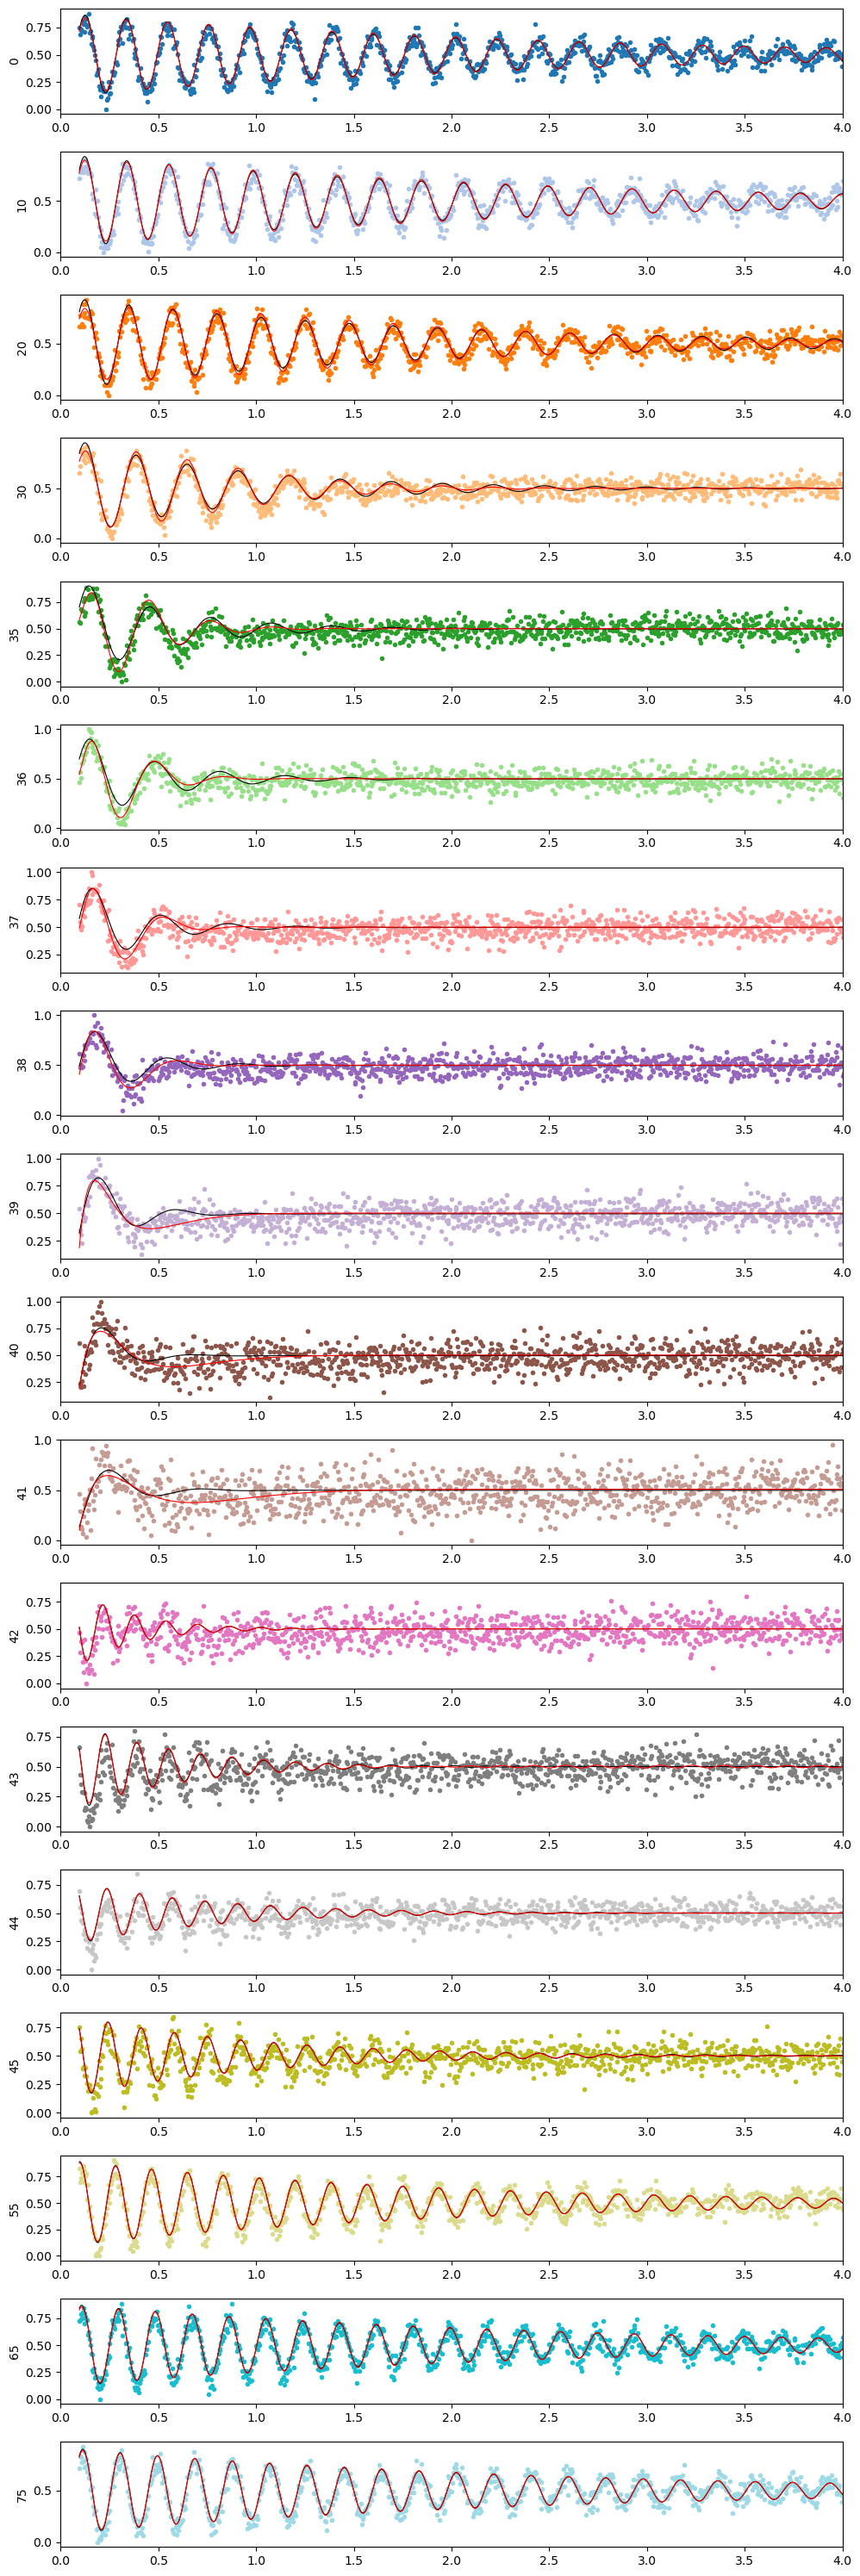

In [355]:
fig, axs= plt.subplots(nrows=N, figsize= [ 10,30])

for n in range(N):
    axs[n].plot(t_us[:idx], q1_x_1[indices[n],:idx],'.', color=colors[n])
    axs[n].plot(t_us[:idx], damped_oscillation(t_us[:idx], *popt_list_1[indices[n]] ), 'k', linewidth=0.8)
    axs[n].plot(t_us[:idx], damped_oscillation_2_freq(t_us[:idx], *popt_list_1_2freq[indices[n]] ), 'r', linewidth=0.8)
    axs[n].set_xlim([0,4]) 
    # axs[n].set_ylabel(f'detuning={fq2_vec[i_0+n]*1e3 - 3689:.1f}')
    axs[n].set_ylabel(f'{indices[n]}')
    
fig.tight_layout()
# fig.show()

Text(0, 0.5, '$\\Delta fq_1$ (MHz)')

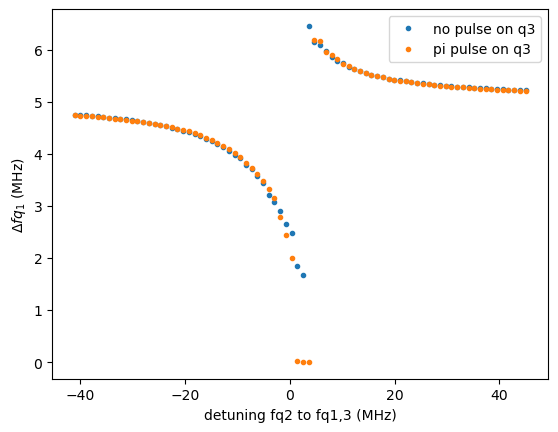

In [357]:
# The curves overlap if we move fq1_1 by 1 MHz to the "left"
plt.plot(fq2_vec*1e3 - 3689, f_vec_0, '.', label = 'no pulse on q3')
plt.plot(fq2_vec*1e3 - 3689, f1_vec_1, '.', label = 'pi pulse on q3')

plt.legend()

plt.xlabel('detuning fq2 to fq1,3 (MHz)')
plt.ylabel('$\Delta fq_1$ (MHz)')

Text(0, 0.5, '$\\Delta fq_1$ (MHz)')

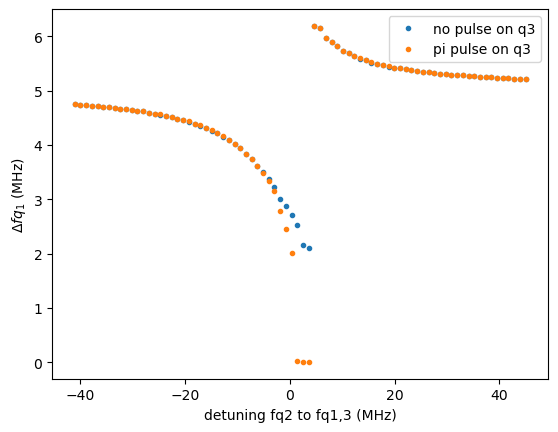

In [358]:
# The curves overlap if we move fq1_1 by 1 MHz to the "left"
plt.plot(fq2_vec*1e3 - 3689, f_vec_1, '.', label = 'no pulse on q3')
plt.plot(fq2_vec*1e3 - 3689, f1_vec_1, '.', label = 'pi pulse on q3')

plt.legend()

plt.xlabel('detuning fq2 to fq1,3 (MHz)')
plt.ylabel('$\Delta fq_1$ (MHz)')

Text(0, 0.5, '$\\Delta fq_1$ (MHz)')

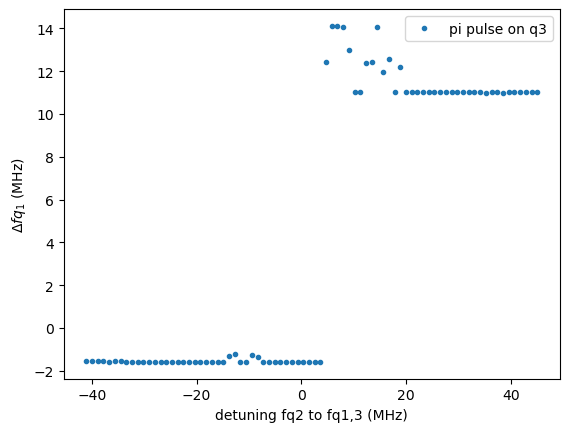

In [342]:
 # The curves overlap if we move fq1_1 by 1 MHz to the "left"
plt.plot(fq2_vec*1e3 - 3689, f2_vec_1, '.', label = 'pi pulse on q3')

plt.legend()

plt.xlabel('detuning fq2 to fq1,3 (MHz)')
plt.ylabel('$\Delta fq_1$ (MHz)')

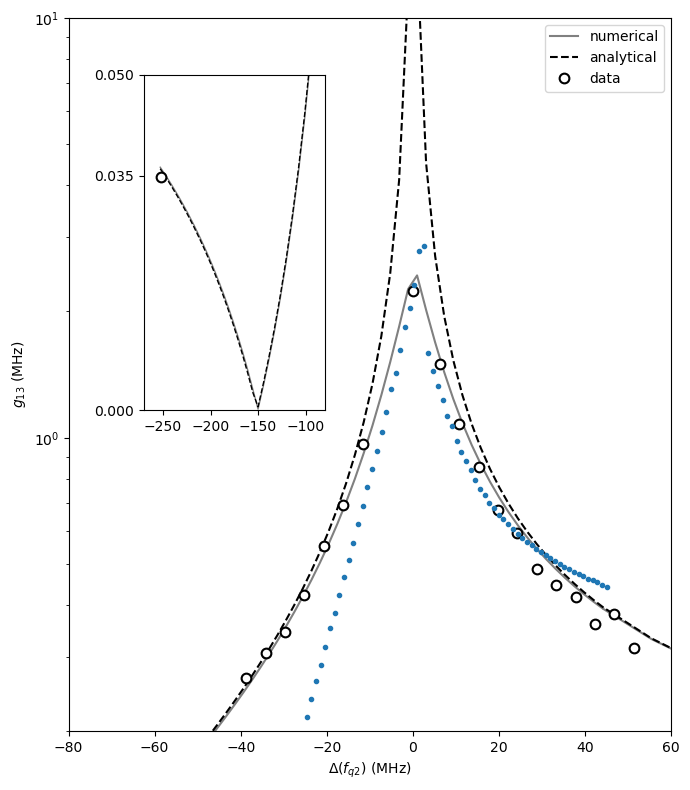

In [95]:
fig, ax = plt.subplots(1, 1, figsize = (7, 8), dpi = 100)

ms = 7
mew = 1.5

detuned_Δfq2 = -252
detuned_g13 = 0.04917

ax.plot(Δfq2 , (σyσy + σxσx)  * 1e3, '-', color='gray', label = 'numerical')
#ax.plot(Δfq2 , σzσz  * 1e3, color=colors[2], linestyle=':')
ax.plot(Δfq2 , np.abs(g_13_analytic)  * 1e3, '--', color='k', label = 'analytical')

ax.set_xlim(-260, 300)
#ax.yaxis.tick_right()

ax.plot((fq2_set_vec[:7]-f2_of_max_g)*1e3, x0_array_opt[:7]*1e3, color='k', marker='o', mfc = 'white', mew = mew, ls='', ms=ms,label='data')
ax.plot((fq2_set_vec[10:]-f2_of_max_g)*1e3, x0_array_opt[10:]*1e3, color='k', marker='o', mfc = 'white', mew = mew, ls='', ms=ms)
ax.plot(0,3.16/np.sqrt(2), color='k', marker='o', mfc = 'white', mew = mew, ls='', ms=ms)


ax.set_yscale('log')

ax.set_xlabel(r'$\Delta(f_{q2})$ (MHz)')
ax.set_ylabel(r'$g_{13}$ (MHz)')

ax.set_ylim([20e-2, 10])
ax.set_xlim([-80, 60])

# inset Axes....
x1, x2, y1, y2 = -270, -80, 1e-4, 5e-2  # subregion of the original image
axins = ax.inset_axes(
    [0.125, 0.45, 0.3, 0.47],
    xlim=(x1, x2), ylim=(y1, y2))
axins.plot(Δfq2 , (σyσy + σxσx)  * 1e3, '-', lw = 1, color='gray', label = 'theory (numerical)')
axins.plot(Δfq2 , np.abs(g_13_analytic)  * 1e3, '--', lw = 1, color='k', label = 'theory (analytical)')
axins.plot(detuned_Δfq2, detuned_g13/np.sqrt(2), marker='o', mew = mew, ls='', color='k', mfc = 'white', ms=ms)
axins.set_yticks([0, 0.035, 0.05])

# ax.indicate_inset_zoom(axins, edgecolor="black")
ax.legend(loc = 'upper right')

ax.plot(fq2_vec*1e3 - 3689, np.abs(f_vec_0-f_vec_0.mean()), '.', label = 'no pulse on q3')

fig.tight_layout()

# plt.savefig("g_13.pdf", format="pdf", bbox_inches="tight")


# Export or show the figure
# fig.show()